# ML Pipeline

## Data Preparation

In [ ]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Extracting refined dataset from Google Storage Bucket

In [ ]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [ ]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/03_refined/df_windowed_full.parquet"
base_dataset =  pd.read_parquet(path)

df = base_dataset.copy()

KeyboardInterrupt: 

In [ ]:
df[['Papel','Tipo','Setor','Subsetor']]

,Papel,Tipo,Setor,Subsetor
24,ABCB4,PN,Intermediários Financeiros,Bancos
25,ABCB4,PN,Intermediários Financeiros,Bancos
26,ABCB4,PN,Intermediários Financeiros,Bancos
27,ABCB4,PN,Intermediários Financeiros,Bancos
28,ABCB4,PN,Intermediários Financeiros,Bancos
...,...,...,...,...
91432,ORVR3,ON,Água e Saneamento,Água e Saneamento
91457,POWE3,ON,Energia Elétrica,Energia Elétrica
91458,POWE3,ON,Energia Elétrica,Energia Elétrica
91483,WEST3,ON,Programas e Serviços,Programas e Serviços


In [ ]:
df = df[df.columns.sort_values()]

In [ ]:
df.shape

(76852, 311)

## Select Features

In [ ]:
features = [
                'Empresa', 'Papel',
                'year_last', 'month_last',
                'besst_1', 'besst_2',
                'Setor','Tipo',
                'Lucro_Liquido_12m_category',
                'dy_label',
                'dy_median_last', 'dy_median_max','dy_median_min','dy_spread','dy_mean_std','dy_mean_last', 'dy_median_ref_min',#add dy relativo
                'euro_last','euro_mean', #add euro relativo
                'evebit_mean_ref_mean','evebit_mean_last','evebit_mean_mean', #add evebit relativo
                'c5y_mean_last','c5y_mean_mean', #add c5y relativo
                'cotacao_max_ref_max','cotacao_mean_ref_mean','cotacao_mean_ref_std', 'cotacao_mean_last', 'cotacao_mean_mean',#add cotacao relativo
                'divbpatr_max_ref_max','divbpatr_mean_last','divbpatr_mean_mean', #add divbpatr relativo
                'dolar_comercial_last','dolar_comercial_mean', #add euro relativo
                'ibovespa_spread','ibovespa_spread_relevance','ibovespa_last','ibovespa_mean',#add ibovespa relativo
                'pib_dolarizado_last','pib_dolarizado_mean', #add pib_dolarizado relativo
                'preco_do_petroleo_last','preco_do_petroleo_mean', #add preco_do_petroleo relativo
                'igpm_last','igpm_mean',#add igpm relativo
                'ipca_last','ipca_mean',#add ipca relativo
                'selic_last','selic_mean',#add igpm relativo
                'liq2m_mean_ref_mean','liq2m_mean_last','liq2m_mean_mean', #add liq2m relativo
                'liqc_mean_ref_mean','liqc_mean_last','liqc_mean_mean', #add liqc relativo
                'mrgebit_mean_ref_mean','mrgebit_mean_last','mrgebit_mean_mean', #add mrgebit relativo
                'mrgliq_mean_ref_mean','mrgliq_mean_last','mrgliq_mean_mean', #add mrgliq relativo
                'pa_mean_ref_mean','pa_mean_last', 'pa_mean_mean',#add pa relativo
                'pl_mean_ref_mean','pl_mean_last', 'pl_mean_mean',#add pa relativo
                'pcg_mean_ref_mean','pcg_mean_last', 'pcg_mean_mean',#add pcg relativo
                'pebit_mean_ref_mean','pebit_mean_last', 'pebit_mean_mean',#add pebit relativo
                'pacl_mean_ref_mean','pacl_mean_last', 'pacl_mean_mean',#add pacl relativo
                'psr_mean_ref_mean','psr_mean_last', 'psr_mean_mean',#add psr relativo
                'pvp_mean_ref_mean','pvp_mean_last', 'pvp_mean_mean',#add pvp relativo
                'roe_mean_ref_mean','roe_mean_last', 'roe_mean_mean',#add roe relativo
                'roic_mean_ref_mean','roic_mean_last', 'roic_mean_mean',#add roic relativo
                'patrliq_mean_ref_mean','patrliq_mean_last','patrliq_mean_mean', #add patrliq relativo
            ]

roots = [
            'euro',
            'dy_mean',
            'evebit_mean',
            'c5y_mean',
            'cotacao_mean',
            'divbpatr_mean',
            'dolar_comercial',
            'ibovespa',
            'pib_dolarizado',
            'preco_do_petroleo',
            'igpm',
            'ipca',
            'selic',
            'liq2m',
            'liqc',
            'mrgebit',
            'mrgliq',
            'pa_mean',
            'pl_mean',
            'pcg_mean',
            'pebit_mean',
            'pacl_mean',
            'psr_mean',
            'pvp_mean',
            'roe_mean',
            'roic_mean_last',
            'patrliq_mean'
        ]

setor_encoding = {
    'Computadores e Equipamentos':1,
    'Tecidos, Vestuário e Calçados':2,
    'Máquinas e Equipamentos':3,
    'Equipamentos':4,
    'Automóveis e Motocicletas':5,
    'Bebidas':6,
    'Alimentos Processados':7,
    'Produtos de Uso Pessoal e de Limpeza':8,
    'Utilidades Domésticas':9,
    'Embalagens':10,
    'Materiais Diversos':11,
    'Medicamentos e Outros Produtos':12,
    'Serv.Méd.Hospit. Análises e Diagnósticos':13,
    'Hoteis e Restaurantes':14,
    'Viagens e Lazer':15,
    'Transporte':16,
    'Material de Transporte':17,
    'Serviços Diversos':18,
    'Programas e Serviços':19,
    'Comércio e Distribuição':20,
    'Comércio':21,
    'Telecomunicações':22,
    'Mídia':23,
    'Holdings Diversificadas':24,
    'Serviços Financeiros Diversos':25,
    'Intermediários Financeiros':26,
    'Previdência e Seguros':27,
    'Exploração de Imóveis':28,
    'Químicos':29,
    'Construção e Engenharia':30,
    'Construção Civil':31,
    'Siderurgia e Metalurgia':32,
    'Energia Elétrica':33,
    'Água e Saneamento':34,
    'Gás':35,
    'Petróleo, Gás e Biocombustíveis':36,
    'Mineração':37,
    'Madeira e Papel':38,
    'Agropecuária':39,
    'Diversos':40,
    'Outros':41,
}

In [ ]:
df = df[features]

df['encoded_sectors']    = df['Setor'].replace(setor_encoding)

df['power_valuation']    = df['roe_mean_last']*df['roic_mean_last']*df['roe_mean_mean']*df['roe_mean_mean']
df['power_price']        = df['pvp_mean_last']*df['psr_mean_last']*df['pacl_mean_last']*df['pl_mean_last']*df['pa_mean_last']
df['power_price']        = (df['pl_mean_last']*df['pa_mean_last'])/(df['pl_mean_ref_mean']*df['pa_mean_ref_mean'])
df['power_margin']       = df['mrgliq_mean_last']/1_000_000*df['mrgebit_mean_last']/1_000_000
df['power_buy_flag']     = (df['pl_mean_last']*df['dy_median_last']*df['dy_median_min'])
df['power_stabil']       = df['dy_median_min']/df['dy_mean_std']
df['power_stabil_delta'] = (df['dy_median_max'] - df['dy_median_min'])/df['dy_mean_std']
df['power_min']          = df['dy_median_min']*df['dy_median_ref_min']

In [ ]:
def create_trends(data,roots):
    
    data_out = data.copy()
    for root in roots:
        try:
            data_out[root + '_trend'] = (np.divide(data_out[root + '_last'],data_out[root + '_mean'])-1)*100
        except:
            continue
    return data_out



df = create_trends(df,roots)

In [ ]:
df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50].index

Index(['liq2m_mean_ref_mean', 'patrliq_mean_ref_mean', 'patrliq_mean_mean',
       'patrliq_mean_last', 'power_valuation', 'liq2m_mean_last',
       'liq2m_mean_mean', 'pl_mean_ref_mean', 'evebit_mean_last',
       'pl_mean_last', 'pebit_mean_last', 'evebit_mean_mean', 'pl_mean_mean',
       'pebit_mean_mean', 'patrliq_mean_trend', 'psr_mean_ref_mean',
       'pebit_mean_ref_mean', 'pl_mean_trend', 'evebit_mean_ref_mean',
       'power_min', 'pcg_mean_ref_mean', 'psr_mean_trend', 'pcg_mean_last',
       'pebit_mean_trend', 'pcg_mean_trend', 'pcg_mean_mean',
       'pacl_mean_trend', 'pvp_mean_trend', 'power_price', 'power_buy_flag',
       'mrgebit_mean_ref_mean', 'psr_mean_last', 'evebit_mean_trend',
       'divbpatr_mean_trend', 'psr_mean_mean', 'pacl_mean_ref_mean',
       'pacl_mean_last', 'ibovespa_mean', 'ibovespa_last', 'ibovespa_spread',
       'pa_mean_trend', 'mrgliq_mean_ref_mean', 'roe_mean_ref_mean',
       'pvp_mean_last', 'pacl_mean_mean', 'roic_mean_ref_mean',
       'p

In [ ]:
def transform_dummy(data, features):
    """
    Transform categorical values into numerical values using one-hot encoding.
    
    Parameters:
        data (DataFrame): The DataFrame containing the categorical features to be transformed.
        features (list): List of categorical features to be transformed.
        
    Returns:
        DataFrame: The transformed DataFrame with numerical values for categorical features.
    """
    for feature in features:
        # Generate one-hot encoded columns and append to the DataFrame
        one_hot_encoded = pd.get_dummies(data[feature])
        new_columns = [(str(feature) + '_' + str(col)) for col in one_hot_encoded.columns]
        data[new_columns] = one_hot_encoded
        
        # Drop the original categorical feature from the DataFrame
        data.drop(feature, axis=1, inplace=True)
        
    return data

In [ ]:
def column_name_cleaner(col):
    """
    Clean column names by replacing non-UTF-8 characters with a replacement character.

    Parameters:
        col (str): The column name to be cleaned.

    Returns:
        str: The cleaned column name.
    """
    return col.encode('utf-8', 'replace').decode('utf-8')


In [ ]:
def create_year_month_column(data: pd.DataFrame, year_column: str, month_column: str) -> pd.DataFrame:
    """
    Create a new column 'year_month' in the DataFrame by concatenating values from two columns.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the columns 'year_last' and 'month_last'.
        year_column (str): Name of the column containing the year values.
        month_column (str): Name of the column containing the month values.

    Returns:
        pd.DataFrame: The DataFrame with a new 'year_month' column.
    """
    # Ensure that the specified columns exist in the DataFrame
    if year_column not in data.columns or month_column not in data.columns:
        raise ValueError(f"Columns '{year_column}' and '{month_column}' not found in the DataFrame.")
    
    # Create the 'year_month' column by concatenating the values from 'year_last' and 'month_last' columns
    data['year_month'] = data[year_column].astype(str) + data[month_column].astype(str)
    
    return data

In [ ]:
df.columns = [column_name_cleaner(col) for col in df.columns]

df = create_year_month_column(df, 'year_last', 'month_last')


In [ ]:
object_cols = df.columns[df.dtypes == 'object'] 
print(object_cols)

Index(['Empresa', 'Papel', 'Setor', 'Tipo', 'year_month'], dtype='object')


In [ ]:
bool_cols = df.columns[df.dtypes == 'bool'] 
print(bool_cols)

Index(['besst_1', 'besst_2'], dtype='object')


In [ ]:
df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]

Index(['liq2m_mean_ref_mean', 'patrliq_mean_ref_mean'], dtype='object')

In [ ]:
# dropping columns with maximum values larger than 1 trillion dollars
to_drop = df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]
df = df.drop(to_drop, axis=1)

In [ ]:
# transforming bool_cols to float
df[bool_cols] = df[bool_cols].astype('float64')

In [ ]:
# checking NaN values and inputing median
df.isna().mean().sort_values(ascending=False)[:30]

power_stabil_delta     0.180997
power_stabil           0.180997
divbpatr_mean_trend    0.135221
psr_mean_trend         0.110355
pacl_mean_trend        0.105345
pcg_mean_trend         0.105345
evebit_mean_trend      0.103498
pebit_mean_trend       0.101663
power_price            0.101663
pa_mean_trend          0.096068
c5y_mean_trend         0.016083
pl_mean_trend          0.005595
roe_mean_trend         0.005595
pvp_mean_mean          0.000000
pacl_mean_last         0.000000
pvp_mean_ref_mean      0.000000
psr_mean_mean          0.000000
psr_mean_last          0.000000
psr_mean_ref_mean      0.000000
pacl_mean_mean         0.000000
roe_mean_ref_mean      0.000000
pvp_mean_last          0.000000
Empresa                0.000000
pacl_mean_ref_mean     0.000000
pebit_mean_mean        0.000000
roe_mean_mean          0.000000
pebit_mean_last        0.000000
pebit_mean_ref_mean    0.000000
pcg_mean_mean          0.000000
pcg_mean_last          0.000000
dtype: float64

In [ ]:
# inpute 0 for missing values
df.fillna(0, inplace=True)

In [ ]:
df = transform_dummy(df,['Tipo'])

In [ ]:
cor = df.corr()['dy_label']

<AxesSubplot:>

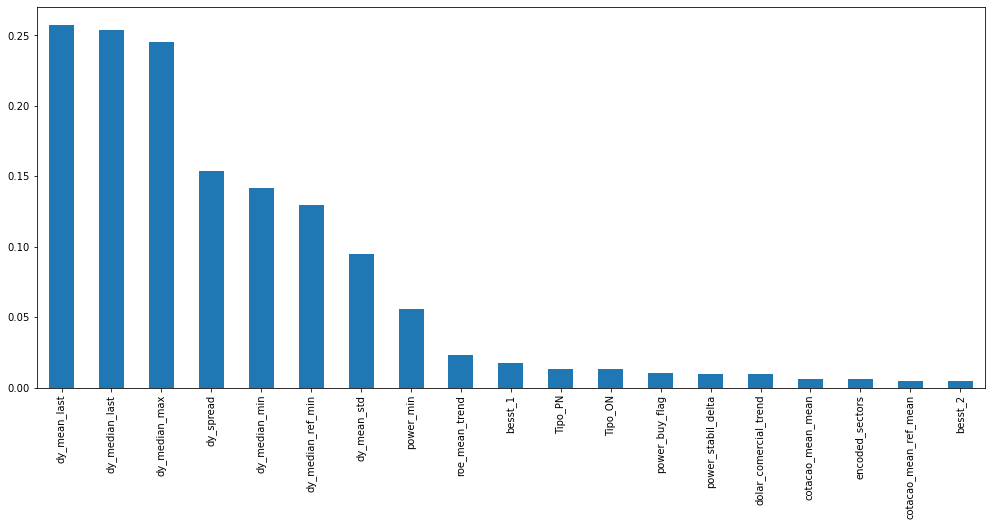

In [ ]:
plt.figure(figsize=(17,7))
np.abs(cor).sort_values(ascending=False)[1:20].plot(kind='bar')

In [ ]:
training_cols = np.abs(cor).sort_values(ascending=False)[0:150].index

In [ ]:
df_to_train = df[['Empresa', 'Papel', 'year_month'] + list(training_cols)].copy()

In [ ]:
df_to_train.sort_values(by='year_month', ascending=False)

,Empresa,Papel,year_month,dy_label,dy_mean_last,dy_median_last,dy_median_max,dy_spread,dy_median_min,dy_median_ref_min,dy_mean_std,power_min,roe_mean_trend,besst_1,Tipo_PN,Tipo_ON,power_buy_flag,power_stabil_delta,dolar_comercial_trend,cotacao_mean_mean,encoded_sectors,cotacao_mean_ref_mean,besst_2,cotacao_max_ref_max,power_stabil,year_last,roe_mean_last,cotacao_mean_last,patrliq_mean_mean,patrliq_mean_last,liq2m_mean_mean,dolar_comercial_last,liqc_mean_mean,liq2m_mean_last,cotacao_mean_ref_std,liqc_mean_last,selic_last,ibovespa_spread_relevance,ibovespa_spread,dolar_comercial_mean,ipca_mean,pib_dolarizado_mean,preco_do_petroleo_mean,ibovespa_mean,igpm_mean,preco_do_petroleo_trend,pib_dolarizado_trend,ipca_trend,ibovespa_trend,igpm_trend,selic_mean,month_last,divbpatr_mean_mean,euro_mean,c5y_mean_mean,divbpatr_max_ref_max,euro_last,Lucro_Liquido_12m_category,divbpatr_mean_last,roe_mean_mean,c5y_mean_last,euro_trend,liqc_mean_ref_mean,mrgebit_mean_mean,selic_trend,pvp_mean_ref_mean,mrgebit_mean_last,pvp_mean_trend,mrgliq_mean_ref_mean,mrgliq_mean_mean,mrgebit_mean_ref_mean,pcg_mean_ref_mean,mrgliq_mean_last,roe_mean_ref_mean,pa_mean_mean,pl_mean_mean,pebit_mean_mean,evebit_mean_mean,pl_mean_ref_mean,roic_mean_mean,pa_mean_last,pl_mean_last,pebit_mean_last,evebit_mean_last,psr_mean_mean,pacl_mean_ref_mean,c5y_mean_trend,power_valuation,pebit_mean_ref_mean,psr_mean_last,pvp_mean_mean,pa_mean_trend,roic_mean_last,pvp_mean_last,pacl_mean_trend,power_price,pebit_mean_trend,power_margin,pa_mean_ref_mean,psr_mean_ref_mean,patrliq_mean_trend,pcg_mean_last,pacl_mean_mean,pl_mean_trend,roic_mean_ref_mean,psr_mean_trend,pcg_mean_trend,evebit_mean_trend,pcg_mean_mean,pacl_mean_last,divbpatr_mean_trend,evebit_mean_ref_mean,cotacao_mean_trend,ibovespa_last,pib_dolarizado_last,preco_do_petroleo_last,igpm_last,ipca_last
91484,WESTWING ON NM,WEST3,2022.04.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,16.635136,0.0,0,1,0.000000e+00,0.000000,13.919038,1.625112,19,0.219928,0.0,0.322738,0.000000,2022.0,-0.283186,3.003097,3.597245e+08,3.892676e+08,7.359318e+05,4.9191,5.888733,1.698111e+06,0.034345,5.716428,0.043739,1.0,240413.5,4.318067,0.70,1287.416667,0.766667,200344.583333,-0.05,20.0,2.000000e+01,20.0,20.0,20.0,0.041739,4.0,-0.086687,4.469975,-0.062435,1.746359,5.18520,3.0,-0.202417,-0.242796,-0.442662,16.000649,2.069110,-0.178697,4.791472,0.403122,-0.077956,-36.912817,-7.299304,-0.107849,-4.149751,0.377255,-0.032764,-79.948311,0.431999,2.407749,-0.946021,0.135027,-0.065563,-0.231794,0.052368,9.079007,-2.893832,-0.115432,0.263238,0.522847,608.999124,2.772916e-03,-2.247735e-01,0.631789,0.544341,-87.877789,-0.166104,0.343409,26.109114,-14.165068,205.895213,2.554168e-15,0.511945,0.137758,8.212693e+00,1.084162,0.938978,277.074540,-7.602229,140.006267,34.279580,-185.487856,0.807392,1.184137,133.504786,2.606193e-02,8.479320e+01,240413.5,1544.9,0.92,-0.06,0.84
56359,PETTENATI PN,PTNT4,2022.04.0,0.045183,0.047450,0.047450,0.050134,0.028300,0.047664,-17.766799,0.000983,-8.468284e-01,-7.160984,0.0,1,0,7.815048e-03,2.513153,13.919038,8.319210,2,1.081593,0.0,1.258281,48.492620,2022.0,0.176171,7.385145,3.450790e+08,3.449088e+08,1.571339e+05,4.9191,1.623627,7.695967e+04,0.141188,1.568800,0.043739,1.0,240413.5,4.318067,0.70,1287.416667,0.766667,200344.583333,-0.05,20.0,2.000000e+01,20.0,20.0,20.0,0.041739,4.0,0.236378,4.469975,0.095977,5.538462,5.18520,3.0,0.319791,0.189760,0.097367,16.000649,1.475820,0.108485,4.791472,2.102448,0.100382,-5.579615,1.522462,0.098520,1.920076,82.977550,0.093331,1.584970,0.531606,4.155658,4.574757,6.822321,301.970843,0.147608,0.495076,3.455463,4.387198,6.821242,0.463345,309.287080,1.447648,8.681565e-04,1.744284e+00,0.436138,1.250423,-6.871560,0.136853,1.180654,320.727520,0.005578,-4.099872,9.368815e-15,1.015628,0.947168,-4.930467e-02,2.090130,-25.045628,-16.849198,3.068116,-5.871709,35.338843,-0.015813,1.544368,-105.373848,35.288167,8.682822e-01,-1.122780e+01,240413.5,1544.9,0.92,-0.06,0.84


In [ ]:
df_to_pred  = df_to_train[df_to_train['year_month']=='2022.04.0'].copy()
df = df_to_train[df_to_train['year_month']!='2022.04.0']

In [ ]:
df['dy_label']

24       0.081976
25       0.081300
26       0.080631
27       0.079991
28       0.079338
           ...   
91379    0.000000
91405    0.000000
91431    0.000000
91457    0.000000
91483    0.000000
Name: dy_label, Length: 76247, dtype: float64

#### Spliting data into training a test data

features X_train: 114
features X_test: 114


R2 score: 0.5327915934850569
Mean squared error: 188.79733735392898
test score: 0.5403886634759087 
train score: 0.9998135170313195


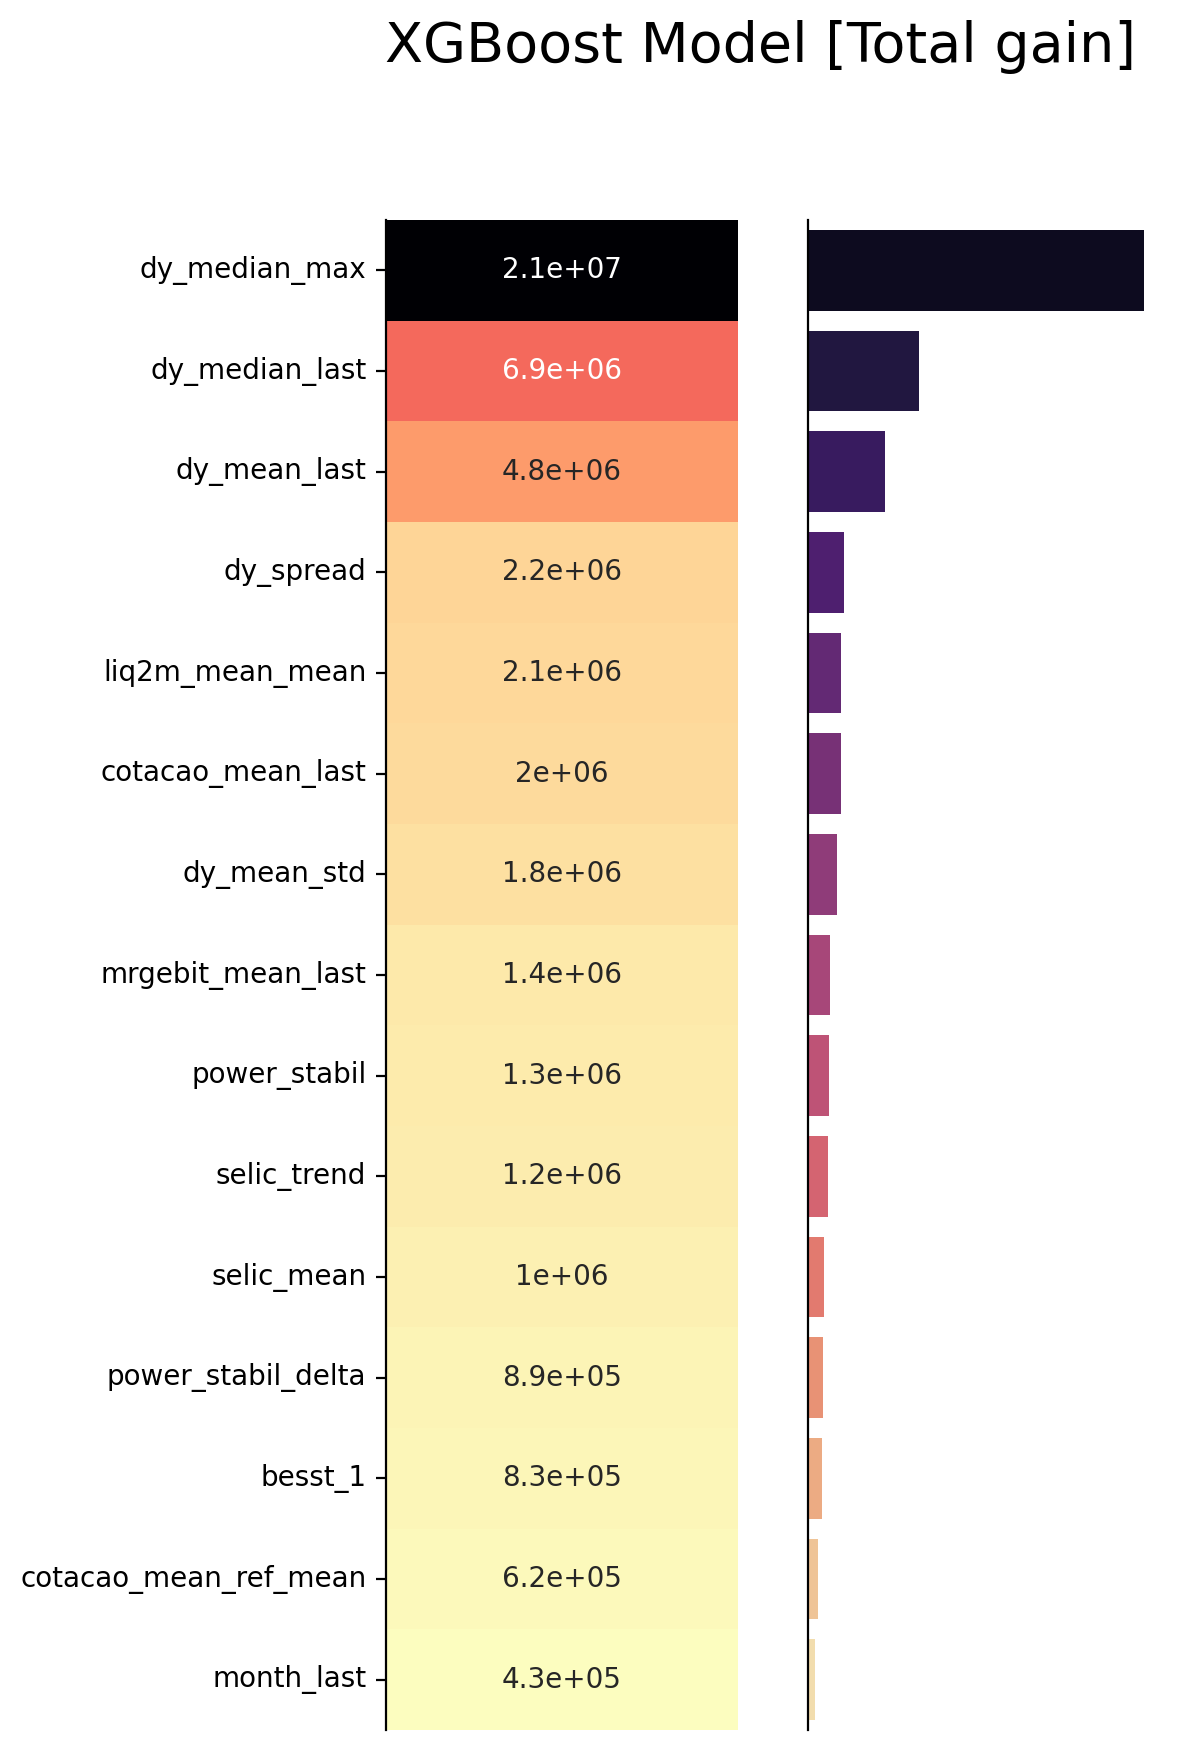

In [ ]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
# X = df[training_features.index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

most_important = most_important_XGBoost_review

### Building a Machine Learning Pipeline 

In [ ]:
def build_pipelines(regressors, transformers):
    pipelines = {}

    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [ ]:

def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [ ]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance
    }

    patch = '../data/03_models/out/'
    filename = patch + f'{str(date.today())}_{algorithm}'

    # return performance
    if sufix != '':
        sufix_ = '_' + sufix
    else:
        sufix_ = sufix

    json.dump(performance, open(filename+f'_results{sufix_}.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+f'{sufix_}.pkl', 'wb'))

    return test_score_r2



def train_models(df, params_path, label, regressors, transformers, cols_to_drop=None, cols_to_train=None, sufix=""):

    # separating the train and target features
    if cols_to_train == None:
        X = df.drop(cols_to_drop, axis=1)
    elif cols_to_train != None:
        print('here we go again')
        X = df[cols_to_train]
    else:
        raise

    y = df[label]

    with open(params_path) as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix)
        print(algorithm, r2)

    return models


In [ ]:
params_path = '../data/03_models/in/params.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_drop)

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1, 0.01],
                         'reg__n_estimators': [100, 500],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsampl

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([35.87033105, 38.45107222, 36.94327927, 36.92028689, 38.64463854]), 'score_time': array([0.04301095, 0.04601073, 0.05701399, 0.06101465, 0.0440104 ]), 'test_r2': array([0.4174414 , 0.38734389, 0.26669458, 0.34864609, 0.14586795]), 'test_mse': array([154.0822187 , 234.41017115, 615.12281625, 308.23368689,
       242.72232399]), 'test_xve': array([0.41746812, 0.3873751 , 0.26669458, 0.34866074, 0.14614233]), 'test_MAPE': array([1.49298049e+14, 1.47335393e+14, 1.70926548e+14, 1.53783443e+14,
       1.76158773e+14])}
CV R2 score: 0.3131987831231139
CV MSE: 310.9142433950923
test r2: 0.5622625128438397
test mse: 185.20778481278577
test explained_variance_score: 0.562292585005699
test MAPE: 95322829766184.28
___________________________________

Best Parameters: {'reg__learning_rate': 0.01, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.5622625128438397
XGBRegressor_Normalizer()
{'fit

In [ ]:
def load_model(path, model_name):
    
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break

    return loaded_model


path = '../data/03_models/out/'

model_name = f'{date.today()}_LGBMRegressor_Normalizer().pkl'

lgb_model = load_model(path, model_name)


model_name = f'{date.today()}_XGBRegressor_Normalizer().pkl'

xgb_model = load_model(path, model_name)


In [ ]:
def get_feature_importances(model, model_class, features):
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance



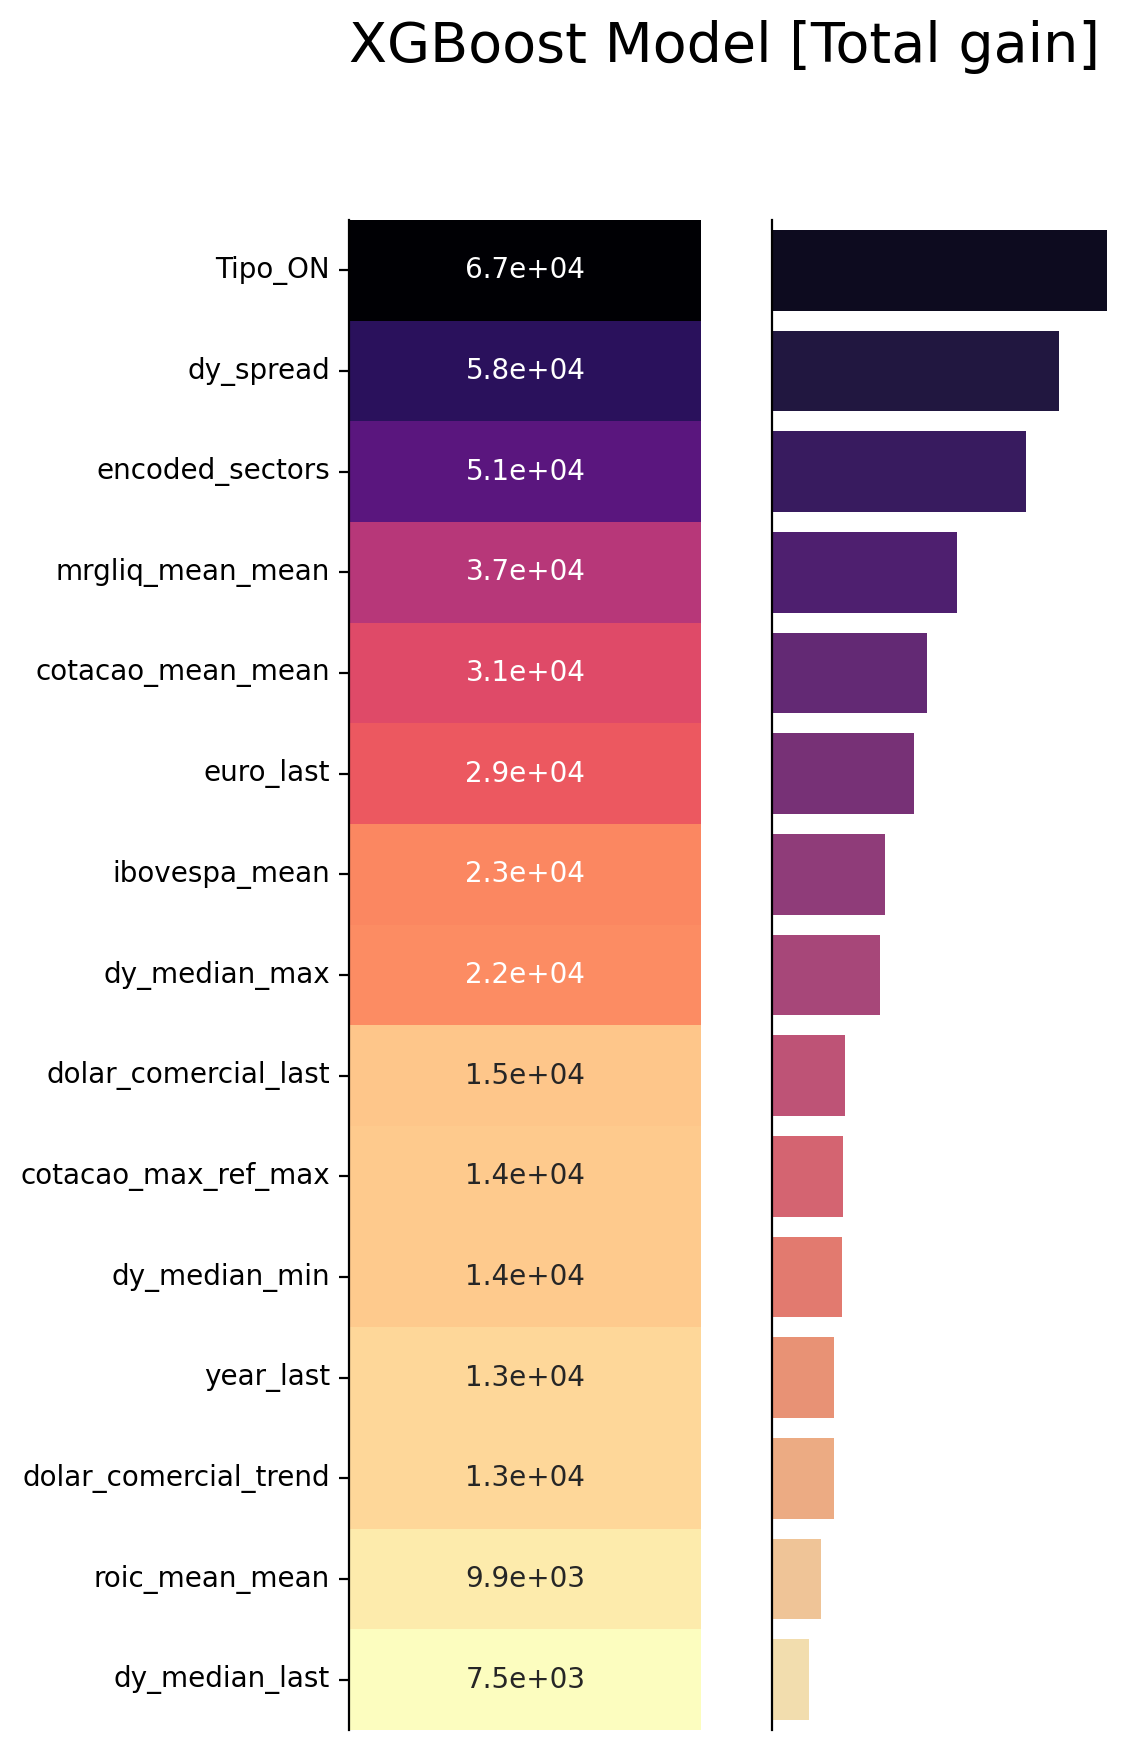

In [ ]:
xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())
plot_importance(xgb_feature_importance, 'Total gain', 'XGBoost Model [Total gain]')

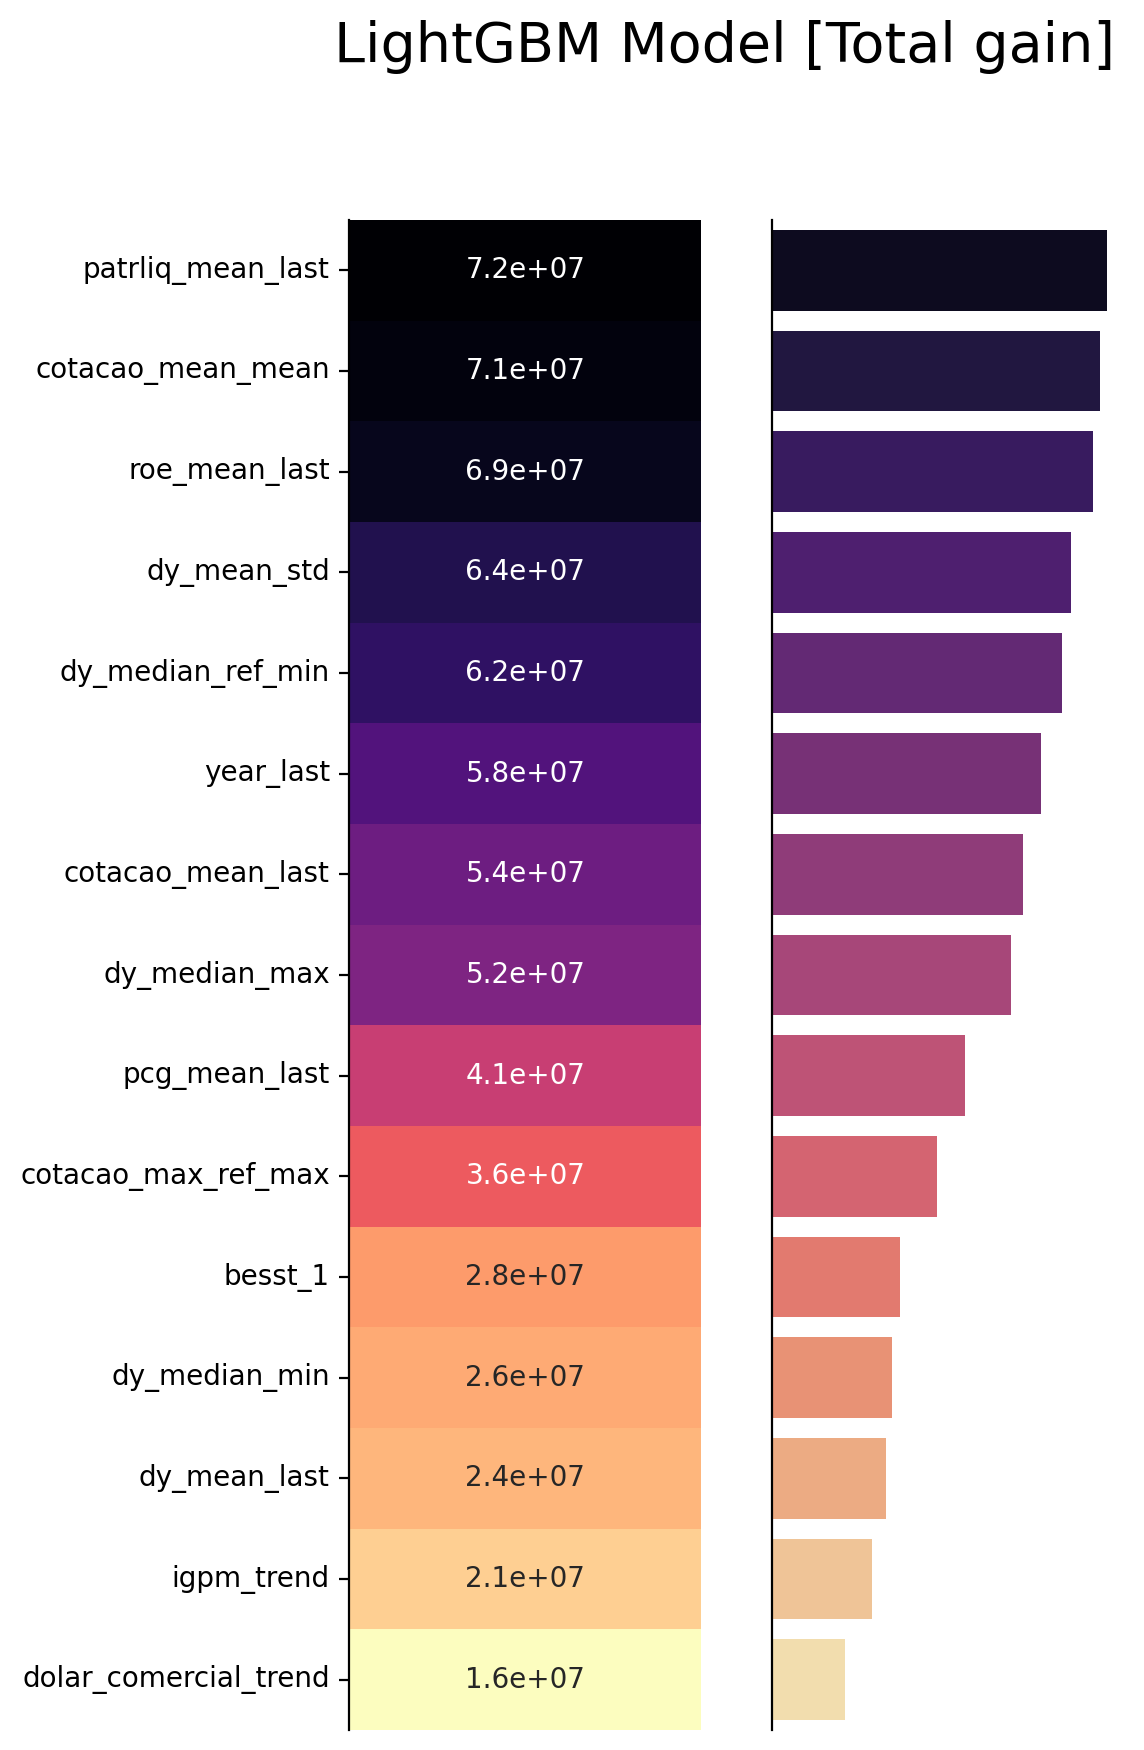

In [ ]:
lgb_feature_importance = get_feature_importances(lgb_model, 'LGB', X.columns.to_list())
plot_importance(lgb_feature_importance, 'Total gain', 'LightGBM Model [Total gain]')

In [ ]:
def calculate_shap_values(model, X_train, X_test):
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, X_train)

        # Calculate SHAP values for the test data
        shap_values = explainer(X_test)

        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")


X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

path = '../data/03_models/out/'

xgb_shap = calculate_shap_values(xgb_model, X_train, X_test)
file_name = 'XGBRegressor_Normalizer()_SHAP.pkl'

# Save SHAP values to a file using pickle
with open(path + file_name, 'wb') as file:
    pickle.dump(xgb_shap, file)


lgb_shap = calculate_shap_values(lgb_model, X_train, X_test)
file_name = 'LGBMRegressor_Normalizer()_SHAP.pkl'

# Save SHAP values to a file using pickle
with open(path + file_name, 'wb') as file:
    pickle.dump(lgb_shap, file)
    

100%|===================| 22816/22875 [04:44<00:00]        

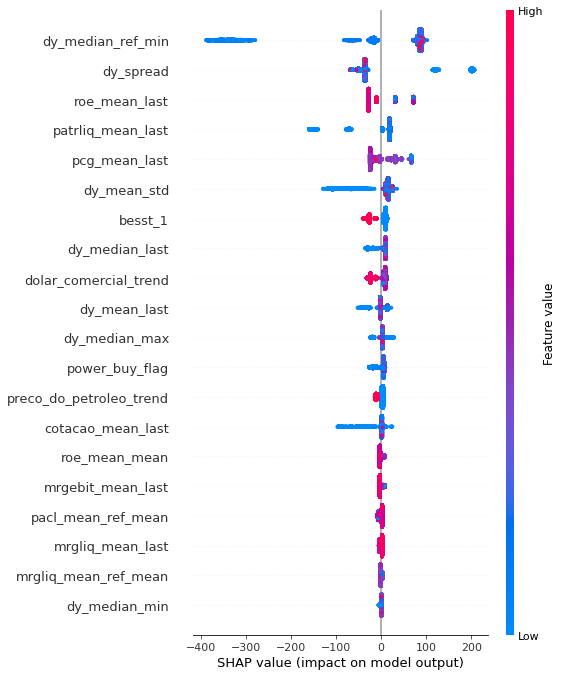

In [ ]:
shap.summary_plot(lgb_shap, X_test)

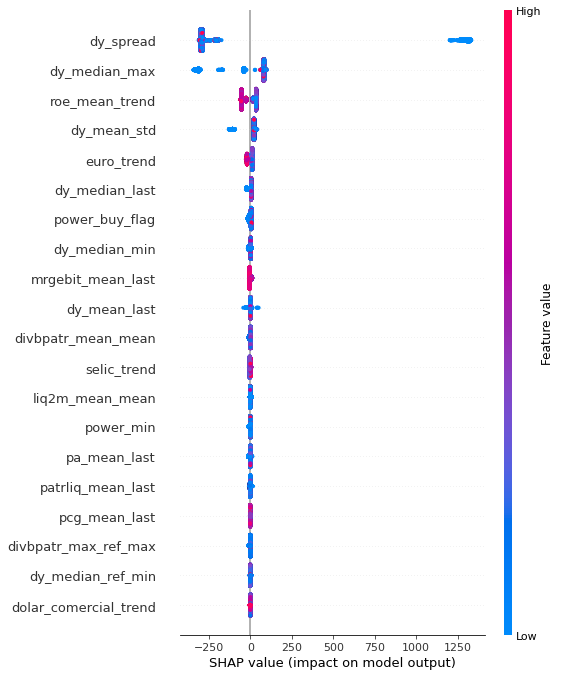

In [ ]:
shap.summary_plot(xgb_shap, X_test)

In [ ]:
d = dict(zip(xgb_shap.feature_names,np.abs(np.sum(xgb_shap.values, axis=0))))
df_xgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

d = dict(zip(lgb_shap.feature_names,np.abs(np.sum(lgb_shap.values, axis=0))))
df_lgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

In [ ]:
n = 70

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.66
xgb in lgb  0.66
double check, cross intersection value 1.0


cols to train:

dy_median_ref_min
dy_mean_std
cotacao_mean_last
dolar_comercial_trend
besst_1
pcg_mean_last
dy_median_last
power_buy_flag
roe_mean_mean
dy_spread
dy_mean_last
cotacao_mean_mean
mrgebit_mean_last
preco_do_petroleo_trend
dy_median_max
Tipo_ON
roe_mean_trend
divbpatr_mean_last
power_price
pa_mean_ref_mean
selic_trend
pebit_mean_last
c5y_mean_mean
power_stabil
pvp_mean_mean
liqc_mean_mean
pa_mean_mean
liq2m_mean_last
roic_mean_last
power_min
pa_mean_last
psr_mean_last
besst_2


In [ ]:
params_path = '../data/03_models/in/params_optimized.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_train=cols_to_train, sufix='feat_selection')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1],
                         'reg__max_depth': [3, 5, 7],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=N

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([36.03444409, 37.2798481 , 36.25151205, 38.20213199, 36.6626308 ]), 'score_time': array([0.04301381, 0.0800252 , 0.07302332, 0.05901837, 0.0720222 ]), 'test_r2': array([0.44074777, 0.66223721, 0.56128797, 0.72968963, 0.24041656]), 'test_mse': array([147.91786429, 129.23242282, 368.00734728, 127.916267  ,
       215.85404388]), 'test_xve': array([0.44077564, 0.66223855, 0.56129037, 0.72969541, 0.24049038]), 'test_MAPE': array([2.52319393e+14, 3.18663593e+14, 3.91571926e+14, 2.32611112e+14,
       1.54424614e+14])}
CV R2 score: 0.5268758297202693
CV MSE: 197.78558905301097
test r2: 0.6365305858968624
test mse: 153.78478427923207
test explained_variance_score: 0.6365622563961428
test MAPE: 216722276567094.47
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 5, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.6365305858968624
XGBRegre

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([35.83900881, 35.62844181, 36.06758213, 37.75395679, 37.75995994]), 'score_time': array([0.04101062, 0.04501057, 0.04200983, 0.10202384, 0.04301   ]), 'test_r2': array([0.47796504, 0.57217006, 0.680161  , 0.78110479, 0.38121767]), 'test_mse': array([138.07418594, 163.69328118, 268.29239703, 103.58558633,
       175.84199587]), 'test_xve': array([0.47805806, 0.57217249, 0.68016404, 0.78111286, 0.38125912]), 'test_MAPE': array([1.29490118e+14, 1.54934821e+14, 1.99279838e+14, 9.41295135e+13,
       8.74828606e+13])}
CV R2 score: 0.578523714002576
CV MSE: 169.89748926986323
test r2: 0.6253596110280408
test mse: 158.51125064402765
test explained_variance_score: 0.6253778761466535
test MAPE: 68872006325847.67
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.6253596110280408
XGBRe

In [ ]:
path = '../data/03_models/out/'

model_name = 'LGBMRegressor_Normalizer()_feat_selection.pkl'

lgb_model = load_model(path, model_name)


# model_name = 'XGBRegressor_Normalizer().pkl'

# xgb_model = load_model(path, model_name)

In [ ]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

In [ ]:
path = '../data/03_models/out/'
model_name = '2023-08-05_LGBMRegressor_Normalizer()_feat_selection.pkl'

with open(path + model_name, 'rb') as file:
        lgb_regressor = pickle.load(file)

df_to_pred['dy_pred'] = lgb_regressor.predict(X_to_pred[cols_to_train])

In [ ]:
df_to_pred.sort_values(by='dy_pred', ascending=False).iloc[0:50][['Empresa','dy_label','dy_pred']]

,Empresa,dy_label,dy_pred
90456,CELGPAR ON,0.022546,89.868250
34280,INVESTIMENTOS BEMGE ON,0.379082,60.409697
34459,INVESTIMENTOS BEMGE PN,0.144815,57.476008
37860,GUARARAPES CONFECÇÕES PN,-0.051209,24.977910
45736,TREVISA INVESTIMENTOS SA ON,-0.007409,21.326706
79943,BR PROPERTIES ON NM,0.523386,19.824445
80231,CEEE-D PN N1,0.000000,15.670427
16022,CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA PNA,0.236528,14.649665
81671,VALID ON NM,-0.729558,12.768973
25509,Daycoval PN N1,-0.020984,11.155312


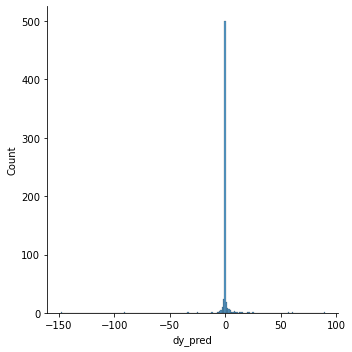

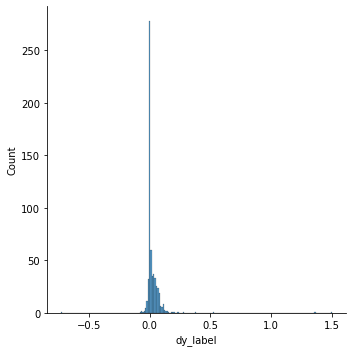

In [ ]:
sns.displot(df_to_pred['dy_pred'],bins=200)
sns.displot(df_to_pred['dy_label'],bins=200)
plt.show()

In [ ]:
cols_to_train = [
    'dy_median_min',
    'roe_mean_last',
    'pl_mean_trend',
    'patrliq_mean_mean',
    'liq2m_mean_mean',
    'besst_1',
    'dolar_comercial_trend',
    'dy_mean_std',
    'dy_mean_mean',
    'pvp_mean_trend',
    'power_buy_flag',
    'dy_median_last',
    'dy_median_max',
    'pib_dolarizado_trend',
    'c5y_mean_trend',
    'dy_mean_last',
    'roe_mean_mean',
    'pl_mean_last',
    'c5y_mean_last',
    'mrgliq_mean_mean',
    'roe_mean_trend',
    'pl_mean_mean',
    'cotacao_mean_mean',
    'besst_2',
    'dy_mean_trend',
    'patrliq_mean_trend',
    'pebit_mean_trend',
    'evebit_mean_last',
    'divbpatr_max_ref_max',
    'roic_mean_last',
    'roic_mean_ref_mean',
    'pa_mean_ref_mean',
    'Lucro_Liquido_12m_category',
    'pvp_mean_ref_mean',
    'pvp_mean_mean',

]

In [ ]:
# Comparar a distribuição de dividendos das empresas indicadas com o besst1 e com o total em quartis
# Plotar a distribuição de dividendos de algum dos primeiros do ranking
# entender alguns outliers